In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, log_loss
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
import json


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
file_path = '/content/drive/MyDrive/ad_10000records.csv'
data = pd.read_csv(file_path)


print(data.head())
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")
print(data.info())


   Daily Time Spent on Site   Age  Area Income  Daily Internet Usage  \
0                     62.26  32.0     69481.85                172.83   
1                     41.73  31.0     61840.26                207.17   
2                     44.40  30.0     57877.15                172.83   
3                     59.88  28.0     56180.93                207.17   
4                     49.21  30.0     54324.73                201.58   

                         Ad Topic Line             City  Gender  \
0      Decentralized real-time circuit         Lisafort    Male   
1       Optional full-range projection  West Angelabury    Male   
2  Total 5thgeneration standardization        Reyesfurt  Female   
3          Balanced empowering success      New Michael  Female   
4  Total 5thgeneration standardization     West Richard  Female   

                        Country            Timestamp  Clicked on Ad  
0  Svalbard & Jan Mayen Islands  2016-06-09 21:43:05              0  
1                     Si

In [4]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing values:")
print(missing_values[missing_values > 0])

# Checking for duplicate rows
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Missing values:
Series([], dtype: int64)
Number of duplicate rows: 215


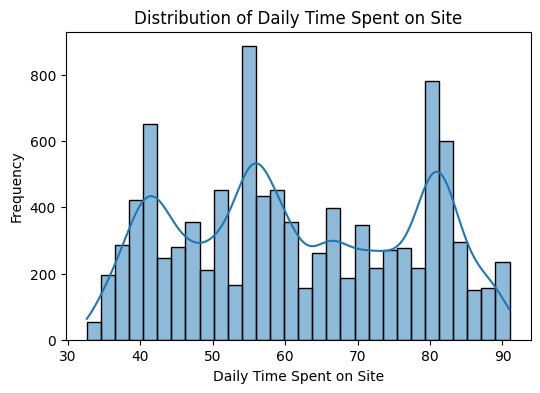

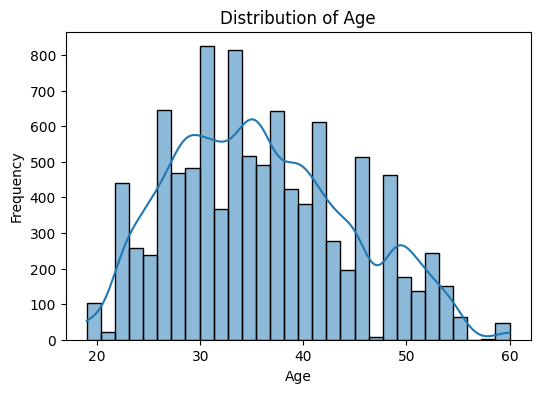

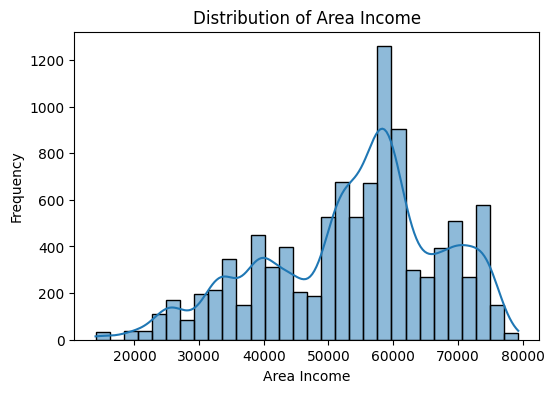

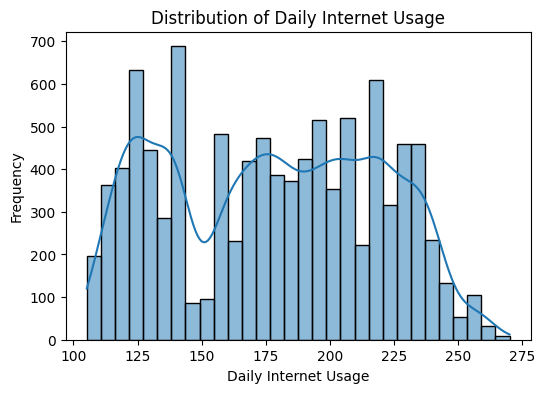

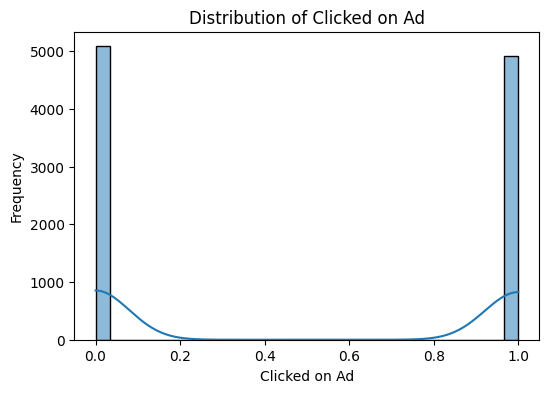

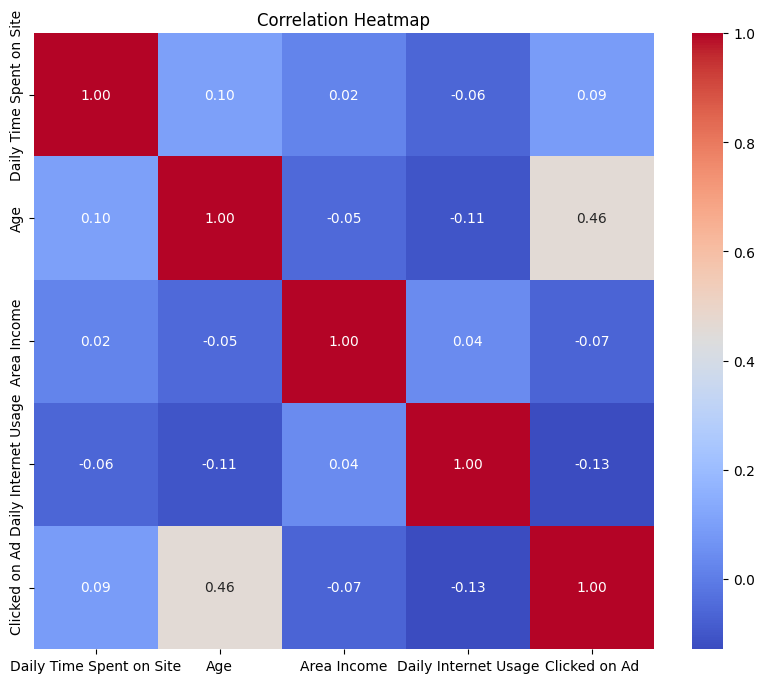

Skipping Ad Topic Line due to high cardinality.
Skipping City due to high cardinality.


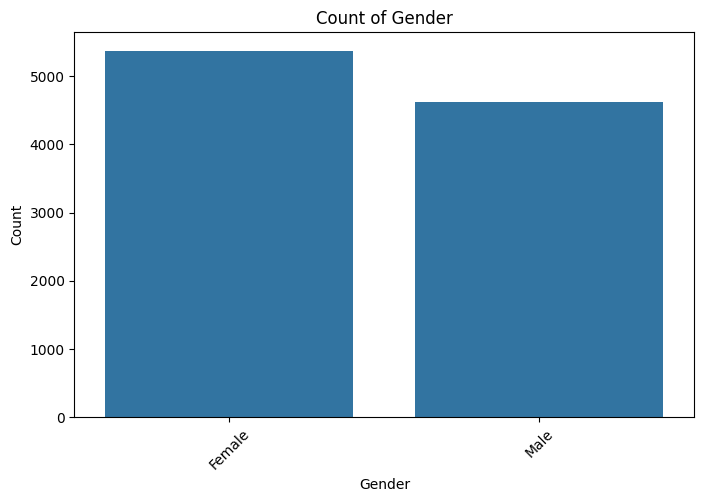

Skipping Country due to high cardinality.
Skipping Timestamp due to high cardinality.


In [5]:
# Distribution of numerical features
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Correlation heatmap
numeric_data = data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Count plots for categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if data[col].nunique() < 50:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=data, x=col, order=data[col].value_counts().index)
        plt.title(f'Count of {col}')
        plt.xticks(rotation=45)
        plt.ylabel('Count')
        plt.show()
    else:
        print(f"Skipping {col} due to high cardinality.")


In [6]:
data['Income_Per_Age'] = data['Area Income'] / data['Age']  # Average income per year of age
data['Time_Per_Internet'] = data['Daily Time Spent on Site'] / data['Daily Internet Usage']

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

print("Engineered Features Preview:")
print(data[['Area Income', 'Age', 'Income_Per_Age', 'Time_Per_Internet']].head())


Engineered Features Preview:
   Area Income   Age  Income_Per_Age  Time_Per_Internet
0     69481.85  32.0     2171.307813           0.360238
1     61840.26  31.0     1994.847097           0.201429
2     57877.15  30.0     1929.238333           0.256900
3     56180.93  28.0     2006.461786           0.289038
4     54324.73  30.0     1810.824333           0.244121


In [7]:
X = data[['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage',
          'Income_Per_Age', 'Time_Per_Internet']]
y = data['Clicked on Ad']
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")


Training Set: (8000, 6), Testing Set: (2000, 6)


In [8]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature Scaling Complete.")


Feature Scaling Complete.


Logistic Regression Accuracy: 0.7145

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.78      0.73      1014
           1       0.74      0.65      0.69       986

    accuracy                           0.71      2000
   macro avg       0.72      0.71      0.71      2000
weighted avg       0.72      0.71      0.71      2000



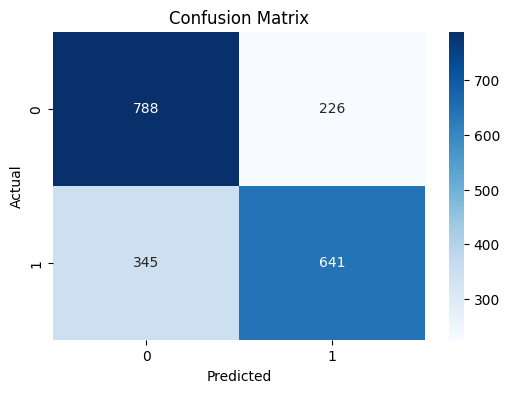

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)


y_pred = logistic_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [10]:
# Training Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluating the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest ROC-AUC: {rf_roc_auc:.4f}")


Random Forest Accuracy: 0.7730
Random Forest ROC-AUC: 0.8510


In [11]:
# Training XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluating the model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"XGBoost ROC-AUC: {xgb_roc_auc:.4f}")


XGBoost Accuracy: 0.7970
XGBoost ROC-AUC: 0.8793


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:13:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [12]:
# Training LightGBM Classifier
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model.fit(X_train_scaled, y_train)

y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# Evaluating the model
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
lgbm_roc_auc = roc_auc_score(y_test, lgbm_model.predict_proba(X_test_scaled)[:, 1])
print(f"LightGBM Accuracy: {lgbm_accuracy:.4f}")
print(f"LightGBM ROC-AUC: {lgbm_roc_auc:.4f}")


[LightGBM] [Info] Number of positive: 3931, number of negative: 4069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491375 -> initscore=-0.034503
[LightGBM] [Info] Start training from score -0.034503


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Accuracy: 0.7965
LightGBM ROC-AUC: 0.8828


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
import joblib
joblib.dump(logistic_model, 'logistic_model.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(lgbm_model, 'lgbm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Models and Scaler Saved for Deployment.")


Models and Scaler Saved for Deployment.
